In [1]:
import gensim
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report, precision_recall_curve

from sklearn.metrics import accuracy_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D



C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
#Reading the dataset

df = pd.read_excel('local.xlsx', engine='openpyxl')
df.head()

,Bangla,Label
0,"খানকির* !#$%&()*+,-./:;<=>?@[\]^_`{|}~।ঃ পোয়া...",Yes
1,আঁরার উরুস্তুল ভালা দেশসেরা জোয়ান এমপির ব্য...,No
2,খানকির পোয়া রোহিঙ্গাওক্কলড়ে দেষত্তূণ বাইড় গো...,Yes
3,"মাশরাফি ভাইয়ুর নান মানুষ নয়, বাচি থাকাক আজার ম...",No
4,কালাইয়া আলারপোয়ালা খাঙ্কির পোয়া অইলদি আস্তা মা...,Yes


In [3]:
df.shape

(1099, 2)

In [4]:
# counting the label in each category
df["Label"].value_counts()


Yes    571
No     528
Name: Label, dtype: int64

In [5]:
#Encoding the Label 
#comment_label = df.Label.factorize()
#comment_label[0]

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Label'] = le.fit_transform(df['Label'])


In [6]:
list(le.classes_)

['No', 'Yes']

In [7]:
list(le.inverse_transform([1,0]))

['Yes', 'No']

In [8]:
df['Label'][0]

1

In [9]:
#comments = df['Bangla']

#tweet = tweet_df.Bangla.values

# Functions definitions for cleaning comments

In [10]:
###########                    Removing Punctuations                  ##############
punc = '!#$%&()*+,-./:;<=>?@[\]^_`{|}~।ঃ'
  
def remove_punctuations(text):
    for ele in text:
        if ele in punc:
            text = text.replace(ele, '')

    return text   

###########                    Removing emojis                  ##############

def remove_emojis(text):
    """
    Result :- string without any emojis in it
    Input :- String
    Output :- String
    """
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)

    without_emoji = emoji_pattern.sub(r'',text)
    return without_emoji


'''def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F" # emoticons
                           u"\U0001F300-\U0001F5FF" # symbols & pictographs
                           u"\U0001F680-\U0001F6FF" # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF" # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
'''
###########                    digits                ##############
def remove_numbers(text):
    """
    Return :- String without numbers
    input :- String
    Output :- String
    """
    number_pattern = r'\d+'
    without_number = re.sub(pattern=number_pattern, repl="", string=text)
    
    return without_number


In [11]:
text = []
def text_preprocessing(sentences):
    for sen in sentences:
        sent = remove_punctuations(sen)
        sent = re.sub('[a-zA-Z]', '', sent)
        sent = remove_emojis(sent)
        sent = remove_numbers(sent)
        
        text.append(sent)
    return text


In [12]:
clean_text = text_preprocessing(df['Bangla'])
len(clean_text)

1099

In [13]:
clean_text[0]

'খানকির   পোয়া রোহিঙ্গা অল বাংলাদেশেত ঢুকিলী  তোর কি আই তোয়ারে বেজ্ঞুনে      '

# Removing Stopwords

In [14]:
stop_words = {'কি','তুই','ইতি', 'তুঁই', 'তোর','তোরে','অই', 'তো', 'নো', 'অনর', 'আই' ,'তোয়ারে','বেজ্ঞুনে','আর', 'আঁর', 'নাটক','ওজ্ঞা','ত', 'আঁই', 'ইঁতি', 'ইঁতারে', 'যেই', 
             'ঈতি', 'ঈতারে', 'লই', 'না', 'অইলি', 'দি', 'তইলি', 'তি', 'হন', 'বিয়া', 'যাই', 'হথা','অয়', 'ওরে', 'চাই','কেওর','যদি',
             'মনয়', 'মনত','বেশি', 'নাকি', 'তরারে', 'যেঁত্তে', 'এত্তে', 'হইলেই', 'গেলি', 'ইয়ান', 'নও', 'অইতু', 'কইউম', 'কিছু', 'হইলি',
             'দন', 'চাইতে', 'তুন', 'দে', 'এই', 'ভরি', 'যেন', 'দে', 'অনে', 'কারে', 'লই', 'অইবু', 'মাজখানে', 'দিয়ে', 'গরি', 'নিজর',
             'হইবুয়', 'আগে', 'কাছে', 'আইস', 'তোয়ারে', 'তুনো', 'আছে', 'দিয়ে', 'যা', 'বলে', 'লাগের', 'নাই', 'কেন', 'চাছুনা', 'বলে', 'আইজু',
             'হদ্দে', 'নান', 'আইয়ি', 'মত', 'লাইবু', 'অইল', 'লই', 'সব', 'গরি', 'দিবু', 'কাছেই', 'হর', 'নেকি', 'কস', 'হই', 'মনে','গরে', 'উধু',
             'জাইবু', 'হয়', 'অইলিদি', 'অলর', 'যআইত', 'পারে', 'তুরা', 'নে', 'এত', 'ইতিরে' 'হনে', 'ওদা', 'পরে', 'রহম', 'লাগে', 'ইয়ন',
             'চাইতাম', 'তা', 'যা', 'লগে', 'তে','কেও', 'ন', 'পার', 'ইবা', 'চাই','এবং', 'হনো', 'যাই', 'ওই', 'এন', 'চাই', 'সেই', 'হতা' }
remove_stop_text = []
def filter_stop_words(sentences, stop_words):
    for i, sentence in enumerate(sentences):
        new_sent = [word for word in sentence.split() if word not in stop_words]
        #clean_text[i] = ' '.join(new_sent)
        remove_stop_text.append(new_sent)
    return remove_stop_text


In [15]:
final_text= filter_stop_words(clean_text, stop_words)
#final_text= filter_stop_words(tweet_df['Bangla'], stop_words)

In [16]:
len(final_text)

1099

In [17]:
len(final_text)

1099

In [18]:
w2v_model = gensim.models.Word2Vec(final_text,
                              min_count = 1,
                               window=5,
                                   epochs = 20 
                             )

In [19]:
w2v_model.wv.key_to_index

{'মাগি': 0,
 'মাগির': 1,
 'পোস্ট': 2,
 'দুধ': 3,
 'পোয়া': 4,
 'ভালা': 5,
 'হানকি': 6,
 'বালর': 7,
 'বদ্দা': 8,
 'সুন্দর': 9,
 'বড়': 10,
 'চাটগাঁইয়া': 11,
 'ইবে': 12,
 'লায়': 13,
 'গরন': 14,
 'ফালতু': 15,
 'আঁরার': 16,
 'পোন': 17,
 'ইয়েন': 18,
 'ইতার': 19,
 'হাম': 20,
 'বউত': 21,
 'ভাষা': 22,
 'পানি': 23,
 'গ্রুপ': 24,
 'কা': 25,
 'অল': 26,
 'মাগিরে': 27,
 'ফিডে': 28,
 'এগিন': 29,
 'ভাই': 30,
 'আছিল': 31,
 'এপ্রুভ': 32,
 'কিন্তু': 33,
 'দরহার': 34,
 'ঠিক': 35,
 'সানাই': 36,
 'নু': 37,
 'যে': 38,
 'ও': 39,
 'আঁরা': 40,
 'চিটাইঙ্গে': 41,
 'হানকির': 42,
 'মানুষ': 43,
 'এক্কান': 44,
 'জিনিস': 45,
 'লেহা': 46,
 'গ্রুপুত': 47,
 'মারি': 48,
 'গ্রুপুর': 49,
 'মতো': 50,
 'এহন': 51,
 'আলার': 52,
 'দিয়ুম': 53,
 'বাইর': 54,
 'নতুন': 55,
 'মাইয়া': 56,
 'আরো': 57,
 'ইতারে': 58,
 'লাই': 59,
 'মাইয়াপোয়া': 60,
 'পরিবু': 61,
 'আফা': 62,
 'গরম': 63,
 'গেইয়ি': 64,
 'নাম': 65,
 'এক': 66,
 'বত': 67,
 'মজা': 68,
 'মিনিটে': 69,
 'চোদা': 70,
 'হত্তুন': 71,
 'পুরাই': 72,
 'হষ্ট': 73,
 'হেডার': 74,
 'আবার': 75,
 

In [20]:
w2v_model.wv.most_similar('ভালোবাসি')

[('হাই', 0.9103826284408569),
 ('ফেলাই', 0.9083652496337891),
 ('লায়', 0.9065624475479126),
 ('আরো', 0.9060927629470825),
 ('পোয়া', 0.9060128331184387),
 ('ভাষা', 0.9050499796867371),
 ('গ্রুপ', 0.9046618938446045),
 ('পোন', 0.9041720628738403),
 ('বানাই', 0.9039822220802307),
 ('চাটগাঁইয়া', 0.9038355946540833)]

In [21]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(final_text)

In [22]:
vocab_size = len(tokenizer.word_index) + 1
vocab_size

4639

In [23]:
W2V_SIZE = 100
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(4639, 100)


In [24]:
print(tokenizer.word_index)

{'মাগি': 1, 'মাগির': 2, 'পোস্ট': 3, 'দুধ': 4, 'পোয়া': 5, 'ভালা': 6, 'হানকি': 7, 'বালর': 8, 'বদ্দা': 9, 'বড়': 10, 'সুন্দর': 11, 'চাটগাঁইয়া': 12, 'ইবে': 13, 'লায়': 14, 'আঁরার': 15, 'গরন': 16, 'ফালতু': 17, 'পোন': 18, 'ইয়েন': 19, 'ইতার': 20, 'হাম': 21, 'ভাষা': 22, 'বউত': 23, 'অল': 24, 'কা': 25, 'গ্রুপ': 26, 'পানি': 27, 'আছিল': 28, 'ভাই': 29, 'মাগিরে': 30, 'এগিন': 31, 'ফিডে': 32, 'এপ্রুভ': 33, 'কিন্তু': 34, 'ঠিক': 35, 'সানাই': 36, 'নু': 37, 'দরহার': 38, 'ও': 39, 'যে': 40, 'চিটাইঙ্গে': 41, 'আঁরা': 42, 'হানকির': 43, 'মানুষ': 44, 'এক্কান': 45, 'জিনিস': 46, 'মারি': 47, 'গ্রুপুর': 48, 'লেহা': 49, 'গ্রুপুত': 50, 'এহন': 51, 'বাইর': 52, 'নতুন': 53, 'দিয়ুম': 54, 'মাইয়া': 55, 'আলার': 56, 'মতো': 57, 'পরিবু': 58, 'মাইয়াপোয়া': 59, 'ইতারে': 60, 'আরো': 61, 'লাই': 62, 'নাম': 63, 'এক': 64, 'গরম': 65, 'আফা': 66, 'গেইয়ি': 67, 'মজা': 68, 'হত্তুন': 69, 'মিনিটে': 70, 'চোদা': 71, 'বত': 72, 'অইলদি': 73, 'হারাপ': 74, 'কুত্তার': 75, 'এড': 76, 'আবার': 77, 'হেডার': 78, 'চুদি': 79, 'পুরাই': 80, 'গইজ্জুন': 81, 'অইয়ি': 8

In [25]:
encoded_docs = tokenizer.texts_to_sequences(final_text)

In [26]:

encoded_docs[7]

[102, 1554, 1555, 1556, 1557]

In [27]:
padded_sequence = pad_sequences(encoded_docs, maxlen=15)

In [28]:
print(final_text[0])
print(encoded_docs[0])
print(padded_sequence[0])

['খানকির', 'পোয়া', 'রোহিঙ্গা', 'অল', 'বাংলাদেশেত', 'ঢুকিলী']
[303, 5, 832, 24, 1522, 1523]
[   0    0    0    0    0    0    0    0    0  303    5  832   24 1522
 1523]


In [29]:
X = np.array(padded_sequence)
y = df['Label']
#y = comment_label[0]

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.33, random_state=42)

# Function definition for Testing the model

In [31]:
Model = list()
Accuracy = list()
precision = list()
recall = list()
F1score = list()


In [32]:
def test_eval(clf_model, X_test, y_test, algo=None):
    # Test set prediction
    #y_prob=clf_model.predict_proba(X_test)
    y_pred=clf_model.predict_classes(X_test,verbose=1)
    #y_pred=clf_model.predict(X_test)

    print('Confusion Matrix')
    print('='*60)
    print(confusion_matrix(y_test,y_pred),"\n")
    print('Classification Report')
    print('='*60)
    print(classification_report(y_test,y_pred),"\n")
    print('Accuracy Score')
    print('='*60)
    print(accuracy_score(y_test, y_pred))
          
    Model.append(algo)
    Accuracy.append(accuracy_score(y_test, y_pred))
    precision.append(precision_score(y_test,y_pred))
    recall.append(recall_score(y_test,y_pred))
    F1score.append(f1_score(y_test,y_pred))
   
    

# Word_2_vec + Simple RNN

In [33]:
maxlen = 15
#embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)
simrnn_model = Sequential()

simrnn_model.add(Embedding(vocab_size ,W2V_SIZE ,weights=[embedding_matrix], input_length = maxlen, name = "embedding", trainable = False))
simrnn_model.add(SimpleRNN(120, activation = 'relu', return_sequences = True))
simrnn_model.add(SimpleRNN(256, activation = 'relu'))
simrnn_model.add(Dense(1, activation = 'sigmoid'))
simrnn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
simrnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 15, 120)           26520     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 256)               96512     
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 587,189
Trainable params: 123,289
Non-trainable params: 463,900
_________________________________________________________________


In [34]:
simrnn = simrnn_model.fit(X_train,y_train,validation_split=0.2, epochs=40)

Epoch 1/40
19/19 [==============================] - 8s 164ms/step - loss: 0.6788 - accuracy: 0.5525 - val_loss: 0.6805 - val_accuracy: 0.5743
Epoch 2/40
19/19 [==============================] - 1s 38ms/step - loss: 0.6592 - accuracy: 0.5995 - val_loss: 0.6502 - val_accuracy: 0.6554
Epoch 3/40
19/19 [==============================] - 1s 46ms/step - loss: 0.6492 - accuracy: 0.6141 - val_loss: 0.6241 - val_accuracy: 0.6689
Epoch 4/40
19/19 [==============================] - 1s 36ms/step - loss: 0.6168 - accuracy: 0.6811 - val_loss: 0.6350 - val_accuracy: 0.6757
Epoch 5/40
19/19 [==============================] - 1s 36ms/step - loss: 0.6018 - accuracy: 0.6741 - val_loss: 0.6598 - val_accuracy: 0.6081
Epoch 6/40
19/19 [==============================] - 1s 32ms/step - loss: 0.6111 - accuracy: 0.6789 - val_loss: 0.6429 - val_accuracy: 0.6554
Epoch 7/40
19/19 [==============================] - 1s 32ms/step - loss: 0.5723 - accuracy: 0.6776 - val_loss: 0.5939 - val_accuracy: 0.6622
Epoch 8/40
1

In [35]:
'''scores = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])
score = model.predict(X_test)
y_p = np.where(score>.5,1,0)
y_p'''

"scores = model.evaluate(X_test, y_test, verbose=0)\nprint('Test loss:', scores[0])\nprint('Test accuracy:', scores[1])\nscore = model.predict(X_test)\ny_p = np.where(score>.5,1,0)\ny_p"

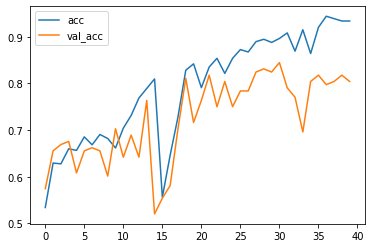

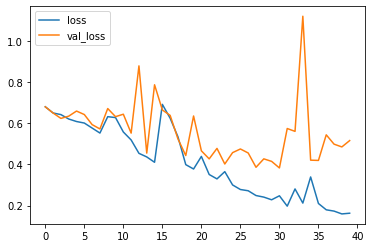

<Figure size 432x288 with 0 Axes>

In [36]:
plt.plot(simrnn.history['accuracy'], label='acc')
plt.plot(simrnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(simrnn.history['loss'], label='loss')
plt.plot(simrnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [37]:
 y_pred=simrnn_model.predict_classes(X_test,verbose=1)

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 1s 9ms/step


In [38]:
accuracy_score(y_test, y_pred)

0.8319559228650137

In [39]:
test_eval(simrnn_model, X_test, y_test, algo='SimpleRNN')

 1/12 [=>............................] - ETA: 0s

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 0s 9ms/step
Confusion Matrix
[[136  39]
 [ 22 166]] 

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.78      0.82       175
           1       0.81      0.88      0.84       188

    accuracy                           0.83       363
   macro avg       0.84      0.83      0.83       363
weighted avg       0.83      0.83      0.83       363
 

Accuracy Score
0.8319559228650137


In [40]:
Model

['SimpleRNN']

In [41]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    print(tw)
    tw = pad_sequences(tw,maxlen=15)
    print(tw)

    pred = simrnn_model.predict(tw)
    print(pred)
    #prediction = int(model.predict(tw).round().item())
    
    if pred < .5:
        return 'No'
    else:
        return 'Yes'
       
        
    #print(prediction)
    #print("Predicted label: ", comment_label[1][sen])


In [42]:
text = 'আই তোয়ারে ভালোবাসি '
predict_sentiment(text)

[[1067]]
[[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
  1067]]
[[0.48298946]]


'No'

# Stacked_LSTM

In [43]:
maxlen = 15

Stacked_LSTM = Sequential() 

Stacked_LSTM.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
Stacked_LSTM.add(SpatialDropout1D(0.25))
Stacked_LSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True ))
Stacked_LSTM.add(Dropout(0.2))
Stacked_LSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True ))
Stacked_LSTM.add(Dropout(0.2))
Stacked_LSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True ))
Stacked_LSTM.add(Dropout(0.2))
Stacked_LSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5, return_sequences=True ))
Stacked_LSTM.add(Dropout(0.2))
Stacked_LSTM.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
Stacked_LSTM.add(Dropout(0.2))
Stacked_LSTM.add(Dense(1, activation='sigmoid')) 
Stacked_LSTM.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(Stacked_LSTM.summary()) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 15, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 15, 50)            30200     
_________________________________________________________________
dropout (Dropout)            (None, 15, 50)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 15, 50)            20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 50)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 15, 50)           

In [44]:
stack_lstm = Stacked_LSTM.fit(X_train,y_train,validation_split=0.2, epochs=40)

Epoch 1/40
19/19 [==============================] - 34s 280ms/step - loss: 0.6918 - accuracy: 0.5559 - val_loss: 0.6743 - val_accuracy: 0.6622
Epoch 2/40
19/19 [==============================] - 2s 114ms/step - loss: 0.6669 - accuracy: 0.6154 - val_loss: 0.6483 - val_accuracy: 0.6081
Epoch 3/40
19/19 [==============================] - 2s 113ms/step - loss: 0.6767 - accuracy: 0.6162 - val_loss: 0.6419 - val_accuracy: 0.6689
Epoch 4/40
19/19 [==============================] - 2s 111ms/step - loss: 0.6512 - accuracy: 0.6428 - val_loss: 0.6359 - val_accuracy: 0.6419
Epoch 5/40
19/19 [==============================] - 2s 133ms/step - loss: 0.6567 - accuracy: 0.6267 - val_loss: 0.6348 - val_accuracy: 0.6486
Epoch 6/40
19/19 [==============================] - 3s 136ms/step - loss: 0.6393 - accuracy: 0.6606 - val_loss: 0.6350 - val_accuracy: 0.6554
Epoch 7/40
19/19 [==============================] - 3s 132ms/step - loss: 0.6340 - accuracy: 0.6570 - val_loss: 0.6393 - val_accuracy: 0.6216
Epoch

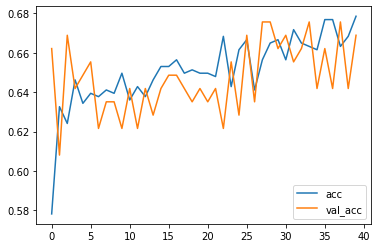

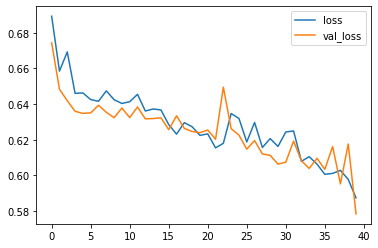

<Figure size 432x288 with 0 Axes>

In [45]:
plt.plot(stack_lstm.history['accuracy'], label='acc')
plt.plot(stack_lstm.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(stack_lstm.history['loss'], label='loss')
plt.plot(stack_lstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [46]:
test_eval(Stacked_LSTM, X_test, y_test, algo='Satcked-LSTM')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 4s 19ms/step
Confusion Matrix
[[ 78  97]
 [ 36 152]] 

Classification Report
              precision    recall  f1-score   support

           0       0.68      0.45      0.54       175
           1       0.61      0.81      0.70       188

    accuracy                           0.63       363
   macro avg       0.65      0.63      0.62       363
weighted avg       0.65      0.63      0.62       363
 

Accuracy Score
0.6336088154269972


# Stacked_BiLSTM

In [47]:
maxlen = 15
bilstm_model = Sequential() 
bilstm_model.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))

#bilstm_model.add(Embedding(vocab_size, embedding_vector_length, input_length=maxlen))
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Bidirectional(LSTM(32)))
bilstm_model.add(Dropout(0.2))
bilstm_model.add(Dense(64, activation='relu'))
bilstm_model.add(Dropout(0.1))
bilstm_model.add(Dense(1, activation='sigmoid'))

 
bilstm_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(bilstm_model.summary()) 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
bidirectional (Bidirectional (None, 15, 128)           84480     
_________________________________________________________________
dropout_5 (Dropout)          (None, 15, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_7 (Dropout)          (None, 64)               

In [48]:
stack_bilstm = bilstm_model.fit(X_train,y_train,validation_split=0.2, epochs=40)

Epoch 1/40
19/19 [==============================] - 22s 257ms/step - loss: 0.6881 - accuracy: 0.6092 - val_loss: 0.6694 - val_accuracy: 0.6351
Epoch 2/40
19/19 [==============================] - 1s 48ms/step - loss: 0.6587 - accuracy: 0.6354 - val_loss: 0.6727 - val_accuracy: 0.6014
Epoch 3/40
19/19 [==============================] - 1s 49ms/step - loss: 0.6414 - accuracy: 0.6405 - val_loss: 0.6496 - val_accuracy: 0.6284
Epoch 4/40
19/19 [==============================] - 1s 50ms/step - loss: 0.6241 - accuracy: 0.6428 - val_loss: 0.6501 - val_accuracy: 0.6351
Epoch 5/40
19/19 [==============================] - 1s 57ms/step - loss: 0.6123 - accuracy: 0.6670 - val_loss: 0.6585 - val_accuracy: 0.6486
Epoch 6/40
19/19 [==============================] - 1s 77ms/step - loss: 0.5972 - accuracy: 0.6953 - val_loss: 0.6556 - val_accuracy: 0.6622
Epoch 7/40
19/19 [==============================] - 2s 104ms/step - loss: 0.5963 - accuracy: 0.7006 - val_loss: 0.6415 - val_accuracy: 0.6689
Epoch 8/40

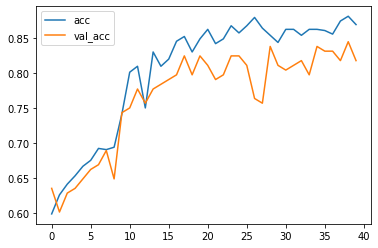

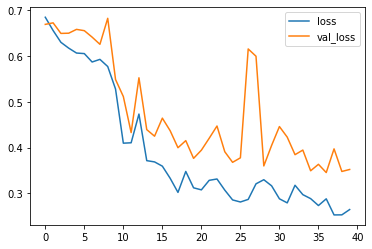

<Figure size 432x288 with 0 Axes>

In [49]:
plt.plot(stack_bilstm.history['accuracy'], label='acc')
plt.plot(stack_bilstm.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(stack_bilstm.history['loss'], label='loss')
plt.plot(stack_bilstm.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [50]:
test_eval(bilstm_model, X_test, y_test, algo='Satcked-Bilstm')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 4s 15ms/step
Confusion Matrix
[[147  28]
 [ 28 160]] 

Classification Report
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       175
           1       0.85      0.85      0.85       188

    accuracy                           0.85       363
   macro avg       0.85      0.85      0.85       363
weighted avg       0.85      0.85      0.85       363
 

Accuracy Score
0.8457300275482094


# Stacked_GRU

In [51]:

maxlen = 15
gru_model = Sequential() 

gru_model.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))

#gru_model.add(Embedding(vocab_size, embedding_vector_length, input_length=maxlen))

gru_model.add(GRU(50, return_sequences=True, activation='relu'))
gru_model.add(Dropout(0.2))
# Second GRU layer
gru_model.add(GRU(100, return_sequences=True, activation='relu'))
gru_model.add(Dropout(0.2))
# Third GRU layer
gru_model.add(GRU(150, return_sequences=True, activation='relu'))
gru_model.add(Dropout(0.2))
# Fourth GRU layer
gru_model.add(GRU(units=50, activation='relu'))
gru_model.add(Dropout(0.2))
# The output layer
gru_model.add(Dense(1, activation='sigmoid'))

 
gru_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(gru_model.summary()) 

stack_gru = gru_model.fit(X_train,y_train,validation_split=0.2, epochs=10)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
gru (GRU)                    (None, 15, 50)            22800     
_________________________________________________________________
dropout_8 (Dropout)          (None, 15, 50)            0         
_________________________________________________________________
gru_1 (GRU)                  (None, 15, 100)           45600     
_________________________________________________________________
dropout_9 (Dropout)          (None, 15, 100)           0         
_________________________________________________________________
gru_2 (GRU)                  (None, 15, 150)           113400    
_________________________________________________________________
dropout_10 (Dropout)         (None, 15, 150)          

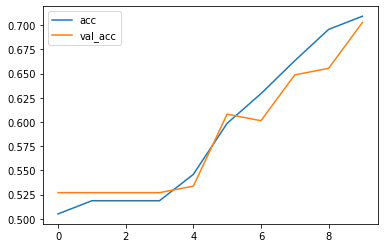

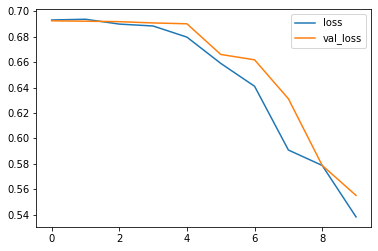

<Figure size 432x288 with 0 Axes>

In [52]:
plt.plot(stack_gru.history['accuracy'], label='acc')
plt.plot(stack_gru.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(stack_gru.history['loss'], label='loss')
plt.plot(stack_gru.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [53]:
test_eval(gru_model, X_test, y_test, algo='Satcked-GRU')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 2s 24ms/step
Confusion Matrix
[[145  30]
 [ 77 111]] 

Classification Report
              precision    recall  f1-score   support

           0       0.65      0.83      0.73       175
           1       0.79      0.59      0.67       188

    accuracy                           0.71       363
   macro avg       0.72      0.71      0.70       363
weighted avg       0.72      0.71      0.70       363
 

Accuracy Score
0.7052341597796143


In [54]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    print(tw)
    tw = pad_sequences(tw,maxlen=15)
    print(tw)

    pred = gru_model.predict(tw)
    print(pred)
    #prediction = int(model.predict(tw).round().item())
    #print(prediction)
    if pred < .5:
        return 'No'
    else:
        return 'Yes'
   # print("Predicted label: ", comment_label[1][sen])


In [55]:
text = 'সানাই অলদি মাগী'
predict_sentiment(text)

[[36, 533, 720]]
[[  0   0   0   0   0   0   0   0   0   0   0   0  36 533 720]]
[[0.544394]]


'Yes'

# Stacked_BiGRU

In [56]:
maxlen = 15
bigru_model = Sequential() 

bigru_model.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))

#bigru_model.add(Embedding(vocab_size, embedding_vector_length, input_length=maxlen))

bigru_model.add(Bidirectional(GRU(32, return_sequences=True)))
bigru_model.add(Dropout(0.2))

bigru_model.add(Bidirectional(GRU(64, return_sequences=True)))
bigru_model.add(Dropout(0.2))

bigru_model.add(Bidirectional(GRU(64)))
bigru_model.add(Dropout(0.2))

bigru_model.add(Dense(64, activation='relu'))
bigru_model.add(Dropout(0.1))
bigru_model.add(Dense(1, activation='sigmoid'))

 
bigru_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(bigru_model.summary()) 


stack_bigru = bigru_model.fit(X_train,y_train,validation_split=0.2, epochs=40)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 15, 64)            25728     
_________________________________________________________________
dropout_12 (Dropout)         (None, 15, 64)            0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 15, 128)           49920     
_________________________________________________________________
dropout_13 (Dropout)         (None, 15, 128)           0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 128)               74496     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)              

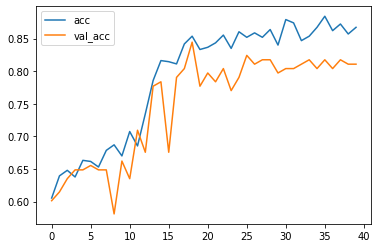

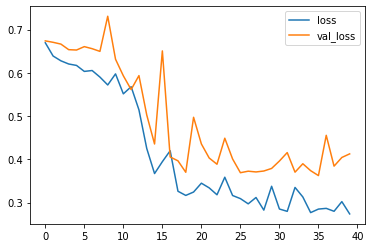

<Figure size 432x288 with 0 Axes>

In [57]:
plt.plot(stack_bigru.history['accuracy'], label='acc')
plt.plot(stack_bigru.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(stack_bigru.history['loss'], label='loss')
plt.plot(stack_bigru.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [58]:
test_eval(bigru_model, X_test, y_test, algo='Stacked-biGRU')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 6s 18ms/step
Confusion Matrix
[[135  40]
 [ 21 167]] 

Classification Report
              precision    recall  f1-score   support

           0       0.87      0.77      0.82       175
           1       0.81      0.89      0.85       188

    accuracy                           0.83       363
   macro avg       0.84      0.83      0.83       363
weighted avg       0.84      0.83      0.83       363
 

Accuracy Score
0.8319559228650137


# Text Classification using CNN

In [59]:
cnn_model = Sequential() 

cnn_model.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
#model.add(SpatialDropout1D(0.25))
cnn_model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5 ,return_sequences = True))
cnn_model.add(Dropout(0.2))

cnn_model.add(Conv1D(32, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(.2))
cnn_model.add(Conv1D(64, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(.2))
cnn_model.add(Conv1D(128, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(.2))
cnn_model.add(Conv1D(256, 3, activation = 'relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dropout(.2))



#model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5 ,return_sequences = True))
#model.add(Dropout(0.2))


cnn_model.add(Dense(1, activation='sigmoid')) 

cnn_model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
cnn_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
lstm_7 (LSTM)                (None, 15, 50)            30200     
_________________________________________________________________
dropout_16 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 13, 32)            4832      
_________________________________________________________________
dropout_17 (Dropout)         (None, 13, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 11, 64)            6208      
_________________________________________________________________
dropout_18 (Dropout)         (None, 11, 64)           

In [60]:
cnn = cnn_model.fit(X_train,y_train,validation_split=0.2, epochs=40)

Epoch 1/40
19/19 [==============================] - 11s 115ms/step - loss: 0.6900 - accuracy: 0.5554 - val_loss: 0.6847 - val_accuracy: 0.5473
Epoch 2/40
19/19 [==============================] - 1s 47ms/step - loss: 0.6804 - accuracy: 0.5610 - val_loss: 0.6432 - val_accuracy: 0.6554
Epoch 3/40
19/19 [==============================] - 1s 46ms/step - loss: 0.6515 - accuracy: 0.6421 - val_loss: 0.6354 - val_accuracy: 0.6554
Epoch 4/40
19/19 [==============================] - 1s 47ms/step - loss: 0.6498 - accuracy: 0.6369 - val_loss: 0.6569 - val_accuracy: 0.6149
Epoch 5/40
19/19 [==============================] - 3s 138ms/step - loss: 0.6624 - accuracy: 0.6002 - val_loss: 0.6384 - val_accuracy: 0.6351
Epoch 6/40
19/19 [==============================] - 1s 63ms/step - loss: 0.6454 - accuracy: 0.6381 - val_loss: 0.6433 - val_accuracy: 0.6554
Epoch 7/40
19/19 [==============================] - 1s 51ms/step - loss: 0.6391 - accuracy: 0.6511 - val_loss: 0.6359 - val_accuracy: 0.6622
Epoch 8/40

In [61]:
test_eval(cnn_model, X_test, y_test, algo='CNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 1s 11ms/step
Confusion Matrix
[[121  54]
 [ 33 155]] 

Classification Report
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       175
           1       0.74      0.82      0.78       188

    accuracy                           0.76       363
   macro avg       0.76      0.76      0.76       363
weighted avg       0.76      0.76      0.76       363
 

Accuracy Score
0.7603305785123967


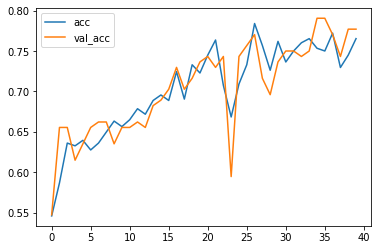

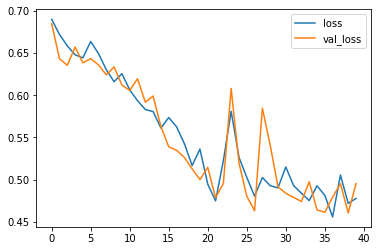

<Figure size 432x288 with 0 Axes>

In [62]:
plt.plot(cnn.history['accuracy'], label='acc')
plt.plot(cnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(cnn.history['loss'], label='loss')
plt.plot(cnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

# CNN + LSTM

In [63]:
lstm_gru = Sequential() 

lstm_gru.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
lstm_gru.add(SpatialDropout1D(0.25))
lstm_gru.add(LSTM(50, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_gru.add(Dropout(0.2))
lstm_gru.add(LSTM(80, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_gru.add(Dropout(0.2))
lstm_gru.add(LSTM(100, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_gru.add(Dropout(0.2))

lstm_gru.add(GRU(50, return_sequences=True, activation='relu'))
lstm_gru.add(Dropout(0.2))
lstm_gru.add(GRU(80, return_sequences=True, activation='relu'))
lstm_gru.add(Dropout(0.2))
lstm_gru.add(GRU(100, activation='relu'))
lstm_gru.add(Dropout(0.2))

lstm_gru.add(Dense(1, activation='sigmoid')) 
lstm_gru.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(lstm_gru.summary()) 

lstmgru = lstm_gru.fit(X_train,y_train,validation_split=0.2, epochs=40)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 15, 100)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 15, 50)            30200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 15, 80)            41920     
_________________________________________________________________
dropout_22 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 15, 100)          

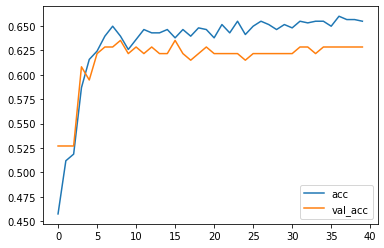

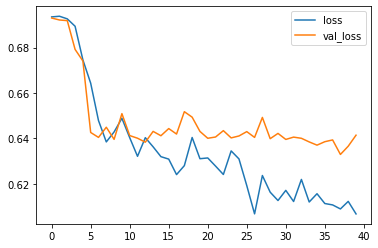

<Figure size 432x288 with 0 Axes>

In [64]:
plt.plot(lstmgru.history['accuracy'], label='acc')
plt.plot(lstmgru.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(lstmgru.history['loss'], label='loss')
plt.plot(lstmgru.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [65]:
test_eval(lstm_gru, X_test, y_test, algo='LSTM+GRU')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 2s 30ms/step
Confusion Matrix
[[ 53 122]
 [ 16 172]] 

Classification Report
              precision    recall  f1-score   support

           0       0.77      0.30      0.43       175
           1       0.59      0.91      0.71       188

    accuracy                           0.62       363
   macro avg       0.68      0.61      0.57       363
weighted avg       0.67      0.62      0.58       363
 

Accuracy Score
0.6198347107438017


# LSTM + CNN

In [66]:

lstm_cnn = Sequential() 
lstm_cnn.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
lstm_cnn.add(SpatialDropout1D(0.25))
lstm_cnn.add(LSTM(50, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_cnn.add(Dropout(0.2))
lstm_cnn.add(LSTM(80, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_cnn.add(Dropout(0.2))
lstm_cnn.add(LSTM(100, dropout=0.5, return_sequences=True, activation='relu' ))
lstm_cnn.add(Dropout(0.2))

lstm_cnn.add(Conv1D(40, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lstm_cnn.add(Dropout(.2))
lstm_cnn.add(Conv1D(90, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lstm_cnn.add(Dropout(.2))
lstm_cnn.add(Conv1D(150, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lstm_cnn.add(Dropout(.2))
lstm_cnn.add(GlobalMaxPooling1D())

lstm_cnn.add(Dense(1, activation='sigmoid')) 
lstm_cnn.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(lstm_cnn.summary()) 

lstmcnn = lstm_cnn.fit(X_train,y_train,validation_split=0.2, epochs=40)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 15, 100)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 15, 50)            30200     
_________________________________________________________________
dropout_27 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 15, 80)            41920     
_________________________________________________________________
dropout_28 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 15, 100)          

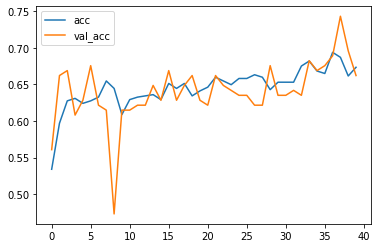

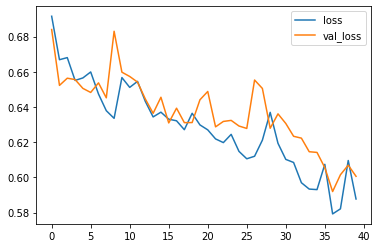

<Figure size 432x288 with 0 Axes>

In [67]:
plt.plot(lstmcnn.history['accuracy'], label='acc')
plt.plot(lstmcnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(lstmcnn.history['loss'], label='loss')
plt.plot(lstmcnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [68]:
test_eval(lstm_cnn, X_test, y_test, algo='LSTM+CNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 1s 19ms/step
Confusion Matrix
[[ 61 114]
 [ 13 175]] 

Classification Report
              precision    recall  f1-score   support

           0       0.82      0.35      0.49       175
           1       0.61      0.93      0.73       188

    accuracy                           0.65       363
   macro avg       0.71      0.64      0.61       363
weighted avg       0.71      0.65      0.62       363
 

Accuracy Score
0.650137741046832


# GRU+CNN

In [69]:
gru_cnn = Sequential() 
gru_cnn.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
gru_cnn.add(SpatialDropout1D(0.25))

gru_cnn.add(GRU(40, return_sequences=True, activation='relu'))
gru_cnn.add(Dropout(0.2))
gru_cnn.add(GRU(80, return_sequences=True, activation='relu'))
gru_cnn.add(Dropout(0.2))
gru_cnn.add(GRU(100, activation='relu', return_sequences = True))
gru_cnn.add(Dropout(0.2))

gru_cnn.add(Conv1D(50, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
gru_cnn.add(Dropout(.2))
gru_cnn.add(Conv1D(80, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
gru_cnn.add(Dropout(.2))
gru_cnn.add(Conv1D(150, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
gru_cnn.add(Dropout(.2))
gru_cnn.add(GlobalMaxPooling1D())


gru_cnn.add(Dense(1, activation='sigmoid')) 
gru_cnn.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(gru_cnn.summary()) 

grucnn = gru_cnn.fit(X_train,y_train,validation_split=0.2, epochs=40)

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 15, 100)           0         
_________________________________________________________________
gru_10 (GRU)                 (None, 15, 40)            17040     
_________________________________________________________________
dropout_33 (Dropout)         (None, 15, 40)            0         
_________________________________________________________________
gru_11 (GRU)                 (None, 15, 80)            29280     
_________________________________________________________________
dropout_34 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
gru_12 (GRU)                 (None, 15, 100)          

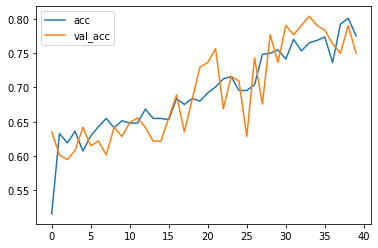

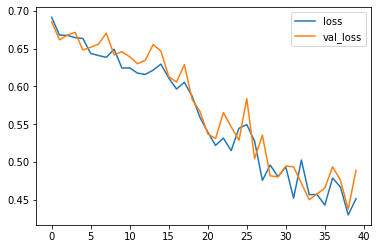

<Figure size 432x288 with 0 Axes>

In [70]:
plt.plot(grucnn.history['accuracy'], label='acc')
plt.plot(grucnn.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(grucnn.history['loss'], label='loss')
plt.plot(grucnn.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")

In [71]:
test_eval(gru_cnn, X_test, y_test, algo='GRU+CNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 3s 19ms/step
Confusion Matrix
[[171   4]
 [ 72 116]] 

Classification Report
              precision    recall  f1-score   support

           0       0.70      0.98      0.82       175
           1       0.97      0.62      0.75       188

    accuracy                           0.79       363
   macro avg       0.84      0.80      0.79       363
weighted avg       0.84      0.79      0.78       363
 

Accuracy Score
0.790633608815427


# LSTM+GRU+CNN

In [72]:
lgc = Sequential() 
lgc.add(Embedding(vocab_size ,W2V_SIZE, weights=[embedding_matrix] , input_length = maxlen, name = "embedding", trainable = False))
#model.add(Embedding(vocab_size, embedding_vector_length, input_length=16, name = "embedding") )
lgc.add(SpatialDropout1D(0.25))
lgc.add(LSTM(50, dropout=0.5, return_sequences=True, activation='relu' ))
lgc.add(Dropout(0.2))
lgc.add(LSTM(80, dropout=0.5, return_sequences=True, activation='relu' ))
lgc.add(Dropout(0.2))
lgc.add(LSTM(100, dropout=0.5, return_sequences=True, activation='relu' ))
lgc.add(Dropout(0.2))

lgc.add(GRU(50, return_sequences=True, activation='relu'))
lgc.add(Dropout(0.2))
lgc.add(GRU(80, return_sequences=True, activation='relu'))
lgc.add(Dropout(0.2))
lgc.add(GRU(100, activation='relu', return_sequences = True))
lgc.add(Dropout(0.2))

lgc.add(Conv1D(40, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lgc.add(Dropout(.2))
lgc.add(Conv1D(80, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lgc.add(Dropout(.2))
lgc.add(Conv1D(150, 3, activation = 'relu'))
#model.add(GlobalMaxPooling1D())
lgc.add(Dropout(.2))
lgc.add(GlobalMaxPooling1D())

lgc.add(Dense(1, activation='sigmoid')) 
lgc.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(lgc.summary()) 

Lgc = lgc.fit(X_train,y_train,validation_split=0.2, epochs=40)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           463900    
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 15, 100)           0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 15, 50)            30200     
_________________________________________________________________
dropout_39 (Dropout)         (None, 15, 50)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 15, 80)            41920     
_________________________________________________________________
dropout_40 (Dropout)         (None, 15, 80)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 15, 100)          

19/19 [==============================] - 3s 137ms/step - loss: 0.6219 - accuracy: 0.6423 - val_loss: 0.6375 - val_accuracy: 0.6419
Epoch 36/40
19/19 [==============================] - 3s 179ms/step - loss: 0.6130 - accuracy: 0.6466 - val_loss: 0.6420 - val_accuracy: 0.6216
Epoch 37/40
19/19 [==============================] - 3s 162ms/step - loss: 0.6228 - accuracy: 0.6504 - val_loss: 0.6359 - val_accuracy: 0.6554
Epoch 38/40
19/19 [==============================] - 3s 158ms/step - loss: 0.6443 - accuracy: 0.6321 - val_loss: 0.6447 - val_accuracy: 0.6284
Epoch 39/40
19/19 [==============================] - 3s 157ms/step - loss: 0.6294 - accuracy: 0.6277 - val_loss: 0.6353 - val_accuracy: 0.6351
Epoch 40/40
19/19 [==============================] - 3s 158ms/step - loss: 0.6291 - accuracy: 0.6372 - val_loss: 0.6346 - val_accuracy: 0.6486


In [73]:
test_eval(lgc, X_test, y_test, algo='LSTM+GRU+CNN')

C:\Users\Sudhakor Das\anaconda3\envs\tensor\lib\site-packages\tensorflow\python\keras\engine\sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


12/12 [==============================] - 39s 34ms/step
Confusion Matrix
[[ 69 106]
 [ 27 161]] 

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.39      0.51       175
           1       0.60      0.86      0.71       188

    accuracy                           0.63       363
   macro avg       0.66      0.63      0.61       363
weighted avg       0.66      0.63      0.61       363
 

Accuracy Score
0.6336088154269972


In [74]:
clf_eval_df = pd.DataFrame({'Model':Model,
                            'Accuracy':Accuracy,
                            'Precision':precision,
                            'Recall':recall,
                            'F1-score':F1score,
                            })

In [75]:
clf_eval_df

,Model,Accuracy,Precision,Recall,F1-score
0,SimpleRNN,0.831956,0.809756,0.882979,0.844784
1,Satcked-LSTM,0.633609,0.610442,0.808511,0.695652
2,Satcked-Bilstm,0.845730,0.851064,0.851064,0.851064
3,Satcked-GRU,0.705234,0.787234,0.590426,0.674772
4,Stacked-biGRU,0.831956,0.806763,0.888298,0.845570
5,CNN,0.760331,0.741627,0.824468,0.780856
6,LSTM+GRU,0.619835,0.585034,0.914894,0.713693
7,LSTM+CNN,0.650138,0.605536,0.930851,0.733753
8,GRU+CNN,0.790634,0.966667,0.617021,0.753247
9,LSTM+GRU+CNN,0.633609,0.602996,0.856383,0.707692


In [78]:
clf_eval_df.to_csv('Word2vec.csv')

In [76]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    print(tw)
    tw = pad_sequences(tw,maxlen=16)
    #pred = model.predict(tw).item()
    #print(pred)
    prediction = int(model.predict(tw).round().item())
    print(prediction)
    print("Predicted label: ", sentiment_label[1][prediction])


In [77]:
test_sentence1 = "খানকির পোলা রোহিঙ্গারা বাংলাদেশে ঢুকলে কি তোর কোন সমস্যাে"
predict_sentiment(test_sentence1)

[[303]]


NameError: name 'model' is not defined

In [ ]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.2, epochs=10)

In [ ]:
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy plot.jpg")


# In[25]:


plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss plot.jpg")


In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=16)
    pred = model.predict(tw).item()
    print(pred)
    prediction = int(model.predict(tw).round().item())
    print(prediction)
    print("Predicted label: ", sentiment_label[1][prediction])


In [ ]:
test_sentence1 = "খুব কষ্ট লাগলো রিকশাওয়ালা চাচার আর্তনাদ দেখে"
predict_sentiment(test_sentence1)

In [ ]:
model = Sequential()
model.add(Embedding(input_dim=unique_vocab+1, output_dim=embedding_dim, input_length=max_len,
                    weights=[embedding_matrix],trainable=False))



model.add(SpatialDropout1D((0.25)))

model.add(Conv1D(filters=300, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2,stride=1))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))

model.add(Conv1D(filters=300, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2,stride=1))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))



model.add(Conv1D(300,4,padding='same',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(advanced_activations.LeakyReLU(alpha=0.3))
model.add(MaxPooling1D(pool_size=2,stride=1))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))

model.add(Conv1D(300,4,padding='same',kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01)))
model.add(advanced_activations.LeakyReLU(alpha=0.3))
model.add(MaxPooling1D(pool_size=2,stride=1))
model.add(BatchNormalization()) 
model.add(SpatialDropout1D((0.5)))



model.add(Bidirectional(CuDNNLSTM(256,kernel_regularizer=regularizers.l1_l2(l1=0.01, l2=0.01),return_sequences=False)))